=== Basic Threading Performance Comparison ===
Running cpu benchmark with various worker counts...


  0%|          | 0/8 [00:00<?, ?it/s]

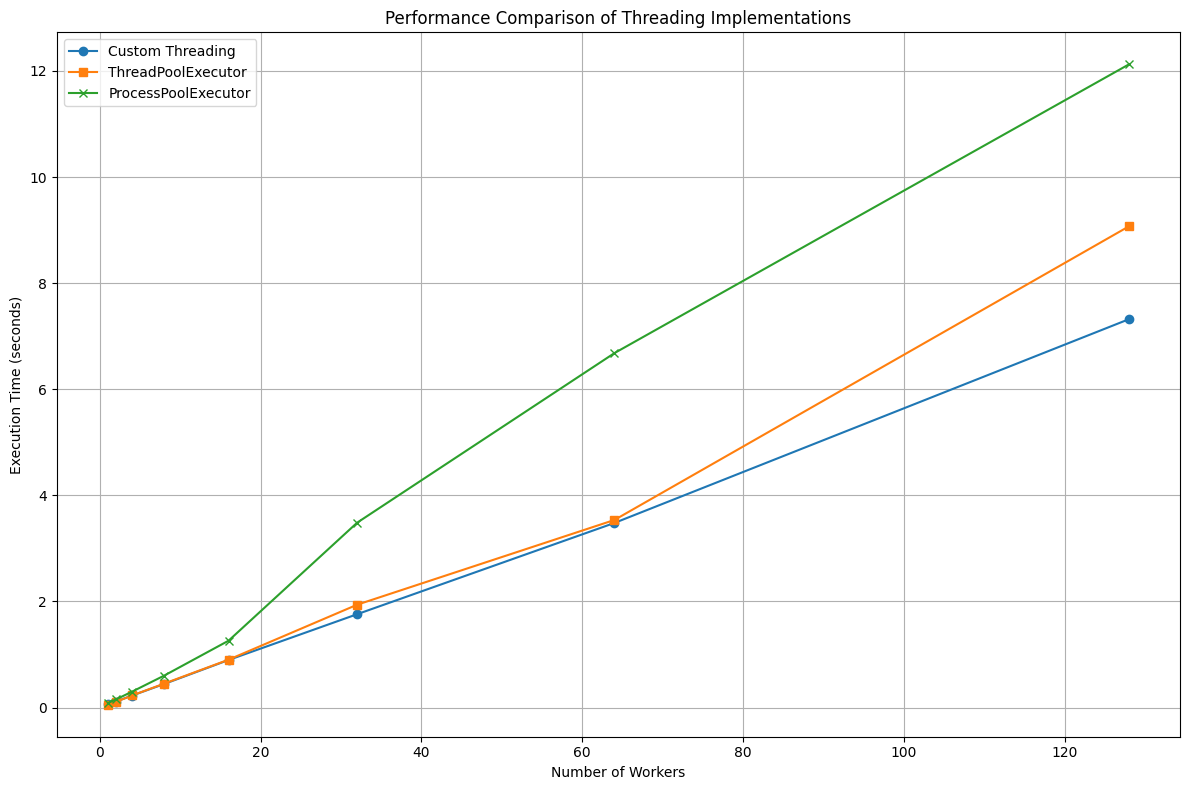


Results Table:


,worker_counts,custom_threading,concurrent_futures_thread,concurrent_futures_process
0,1,0.066638,0.053411,0.085321
1,2,0.113626,0.106956,0.153050
2,4,0.225857,0.227044,0.299442
3,8,0.444313,0.451530,0.602528
4,16,0.896076,0.902092,1.259742
5,32,1.759596,1.938822,3.485235
6,64,3.479700,3.536060,6.681667
7,128,7.320782,9.071653,12.125057



Speedup relative to custom threading:


,worker_counts,ThreadPoolExecutor vs Custom,ProcessPoolExecutor vs Custom
0,1,1.247654,0.781033
1,2,1.062362,0.742409
2,4,0.994773,0.754261
3,8,0.984017,0.737414
4,16,0.993331,0.711317
5,32,0.907559,0.504871
6,64,0.984061,0.520783
7,128,0.806995,0.603773



=== Task Type Comparison (CPU vs Network) ===
Running network benchmark with various worker counts...


  0%|          | 0/5 [00:00<?, ?it/s]

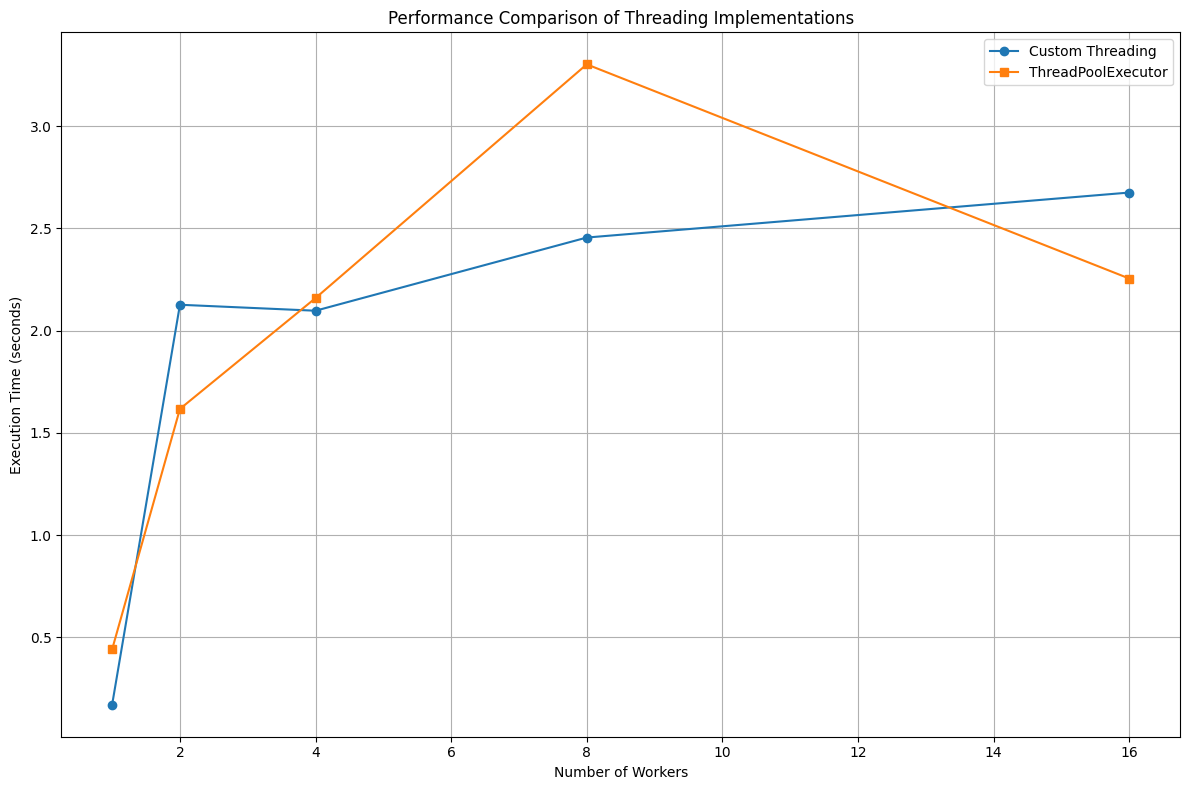


Results Table:


,worker_counts,custom_threading,concurrent_futures_thread,concurrent_futures_process
0,1,0.171453,0.441815,None
1,2,2.126333,1.617205,None
2,4,2.097151,2.159028,None
3,8,2.454835,3.301394,None
4,16,2.674734,2.254669,None



Speedup relative to custom threading:


,worker_counts,ThreadPoolExecutor vs Custom
0,1,0.388065
1,2,1.314820
2,4,0.971340
3,8,0.743575
4,16,1.186309



=== Distributed Systems (Apache-like) Comparison ===
Running distributed systems benchmark with various worker counts...


  0%|          | 0/5 [00:00<?, ?it/s]

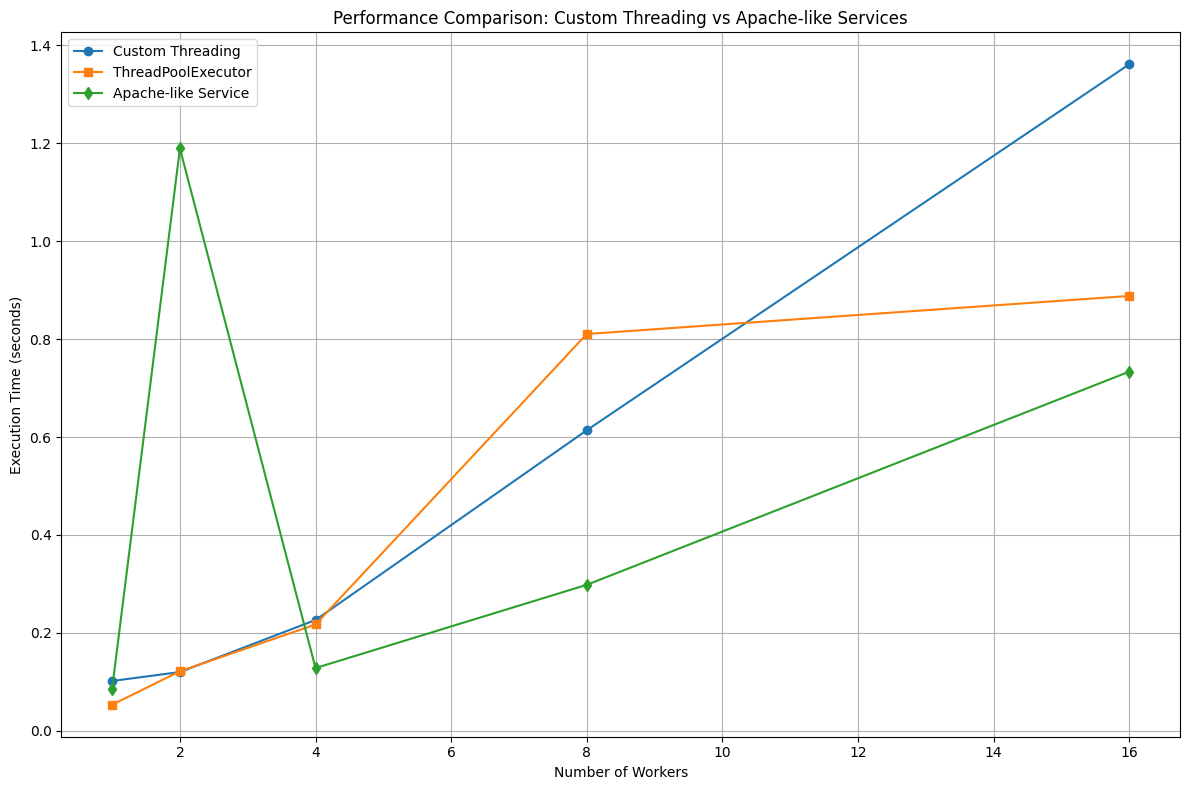


Extended Results Table:


,worker_counts,custom_threading,concurrent_futures_thread,apache_simulated
0,1,0.101779,0.053342,0.086052
1,2,0.120028,0.121615,1.189225
2,4,0.226338,0.217153,0.128196
3,8,0.613753,0.810332,0.298129
4,16,1.361023,0.888084,0.733375



Speedup relative to custom threading:


,worker_counts,ThreadPoolExecutor vs Custom,Apache-like Service vs Custom
0,1,1.908060,1.182771
1,2,0.986955,0.100930
2,4,1.042294,1.765556
3,8,0.757410,2.058682
4,16,1.532539,1.855835


All comparisons completed and results saved.


In [2]:
import time
import threading
import concurrent.futures
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

!pip install -q requests matplotlib numpy pandas tqdm

class ThreadingPerformanceComparison:
    def __init__(self):
        self.results = {
            'worker_counts': [],
            'custom_threading': [],
            'concurrent_futures_thread': [],
            'concurrent_futures_process': []
        }

    def dummy_task(self, task_id):
        result = 0
        for i in range(1000000):
            result += i
        return task_id, result

    def network_task(self, url):
        try:
            response = requests.get(url, timeout=5)
            return url, len(response.content)
        except Exception as e:
            return url, str(e)

    def run_custom_threading(self, worker_count, task_func, task_args):
        results = [None] * worker_count
        threads = []

        def worker_wrapper(idx, arg):
            results[idx] = task_func(arg)

        for i in range(worker_count):
            thread = threading.Thread(target=worker_wrapper, args=(i, task_args[i]))
            threads.append(thread)
            thread.start()

        for thread in threads:
            thread.join()

        return results

    def run_concurrent_futures_thread(self, worker_count, task_func, task_args):
        with concurrent.futures.ThreadPoolExecutor(max_workers=worker_count) as executor:
            futures = {executor.submit(task_func, arg): i for i, arg in enumerate(task_args[:worker_count])}
            results = [None] * worker_count

            for future in concurrent.futures.as_completed(futures):
                idx = futures[future]
                results[idx] = future.result()

            return results

    def run_concurrent_futures_process(self, worker_count, task_func, task_args):
        with concurrent.futures.ProcessPoolExecutor(max_workers=worker_count) as executor:
            futures = {executor.submit(task_func, arg): i for i, arg in enumerate(task_args[:worker_count])}
            results = [None] * worker_count

            for future in concurrent.futures.as_completed(futures):
                idx = futures[future]
                results[idx] = future.result()

            return results

    def benchmark(self, worker_counts, task_type='cpu'):
        print(f"Running {task_type} benchmark with various worker counts...")

        if task_type == 'cpu':
            task_func = self.dummy_task
            max_workers = max(worker_counts)
            task_args = list(range(max_workers))
        else:
            task_func = self.network_task
            urls = [f"https://httpbin.org/delay/{i%3}" for i in range(max(worker_counts))]
            task_args = urls

        for worker_count in tqdm(worker_counts):
            self.results['worker_counts'].append(worker_count)

            start_time = time.time()
            _ = self.run_custom_threading(worker_count, task_func, task_args)
            custom_time = time.time() - start_time
            self.results['custom_threading'].append(custom_time)

            start_time = time.time()
            _ = self.run_concurrent_futures_thread(worker_count, task_func, task_args)
            concurrent_thread_time = time.time() - start_time
            self.results['concurrent_futures_thread'].append(concurrent_thread_time)

            if task_type == 'cpu':
                start_time = time.time()
                _ = self.run_concurrent_futures_process(worker_count, task_func, task_args)
                concurrent_process_time = time.time() - start_time
                self.results['concurrent_futures_process'].append(concurrent_process_time)
            else:
                self.results['concurrent_futures_process'].append(None)

    def plot_results(self):
        df = pd.DataFrame(self.results)

        plt.figure(figsize=(12, 8))
        plt.plot(df['worker_counts'], df['custom_threading'], marker='o', label='Custom Threading')
        plt.plot(df['worker_counts'], df['concurrent_futures_thread'], marker='s', label='ThreadPoolExecutor')

        if not all(x is None for x in df['concurrent_futures_process']):
            plt.plot(df['worker_counts'], df['concurrent_futures_process'], marker='x', label='ProcessPoolExecutor')

        plt.title('Performance Comparison of Threading Implementations')
        plt.xlabel('Number of Workers')
        plt.ylabel('Execution Time (seconds)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        print("\nResults Table:")
        display(df)

        if not df.empty:
            print("\nSpeedup relative to custom threading:")
            speedup_df = pd.DataFrame({
                'worker_counts': df['worker_counts'],
                'ThreadPoolExecutor vs Custom': df['custom_threading'] / df['concurrent_futures_thread']
            })

            if not all(x is None for x in df['concurrent_futures_process']):
                speedup_df['ProcessPoolExecutor vs Custom'] = df['custom_threading'] / df['concurrent_futures_process']

            display(speedup_df)

class RESTAPIClient:
    def __init__(self, base_url="https://httpbin.org"):
        self.base_url = base_url

    def get_data(self, endpoint):
        try:
            response = requests.get(f"{self.base_url}/{endpoint}", timeout=5)
            return response.json() if response.status_code == 200 else None
        except Exception as e:
            return {"error": str(e)}

    def post_data(self, endpoint, data):
        try:
            response = requests.post(f"{self.base_url}/{endpoint}", json=data, timeout=5)
            return response.json() if response.status_code == 200 else None
        except Exception as e:
            return {"error": str(e)}

class DistributedSystemsComparison(ThreadingPerformanceComparison):
    def __init__(self):
        super().__init__()
        self.client = RESTAPIClient()

        self.results['apache_simulated'] = []

    def apache_like_worker(self, task_id):
        endpoint = f"anything/{task_id}"
        data = {"task_id": task_id, "timestamp": time.time()}

        return self.client.post_data(endpoint, data)

    def run_apache_simulation(self, worker_count):
        with concurrent.futures.ThreadPoolExecutor(max_workers=worker_count) as executor:
            futures = {executor.submit(self.apache_like_worker, i): i for i in range(worker_count)}
            results = [None] * worker_count

            for future in concurrent.futures.as_completed(futures):
                idx = futures[future]
                results[idx] = future.result()

            return results

    def benchmark_with_apache(self, worker_counts):
        print(f"Running distributed systems benchmark with various worker counts...")

        for worker_count in tqdm(worker_counts):
            if worker_count not in self.results['worker_counts']:
                self.results['worker_counts'].append(worker_count)

                start_time = time.time()
                _ = self.run_custom_threading(worker_count, self.dummy_task, list(range(worker_count)))
                custom_time = time.time() - start_time
                self.results['custom_threading'].append(custom_time)

                start_time = time.time()
                _ = self.run_concurrent_futures_thread(worker_count, self.dummy_task, list(range(worker_count)))
                concurrent_thread_time = time.time() - start_time
                self.results['concurrent_futures_thread'].append(concurrent_thread_time)

                self.results['concurrent_futures_process'].append(None)

            start_time = time.time()
            _ = self.run_apache_simulation(worker_count)
            apache_time = time.time() - start_time

            if len(self.results['apache_simulated']) < len(self.results['worker_counts']):
                self.results['apache_simulated'].append(apache_time)
            else:
                self.results['apache_simulated'][self.results['worker_counts'].index(worker_count)] = apache_time

    def plot_extended_results(self):
        df = pd.DataFrame(self.results)

        plt.figure(figsize=(12, 8))
        plt.plot(df['worker_counts'], df['custom_threading'], marker='o', label='Custom Threading')
        plt.plot(df['worker_counts'], df['concurrent_futures_thread'], marker='s', label='ThreadPoolExecutor')
        plt.plot(df['worker_counts'], df['apache_simulated'], marker='d', label='Apache-like Service')

        plt.title('Performance Comparison: Custom Threading vs Apache-like Services')
        plt.xlabel('Number of Workers')
        plt.ylabel('Execution Time (seconds)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        print("\nExtended Results Table:")
        display(df[['worker_counts', 'custom_threading', 'concurrent_futures_thread', 'apache_simulated']])

        if not df.empty:
            print("\nSpeedup relative to custom threading:")
            speedup_df = pd.DataFrame({
                'worker_counts': df['worker_counts'],
                'ThreadPoolExecutor vs Custom': df['custom_threading'] / df['concurrent_futures_thread'],
                'Apache-like Service vs Custom': df['custom_threading'] / df['apache_simulated']
            })
            display(speedup_df)

# Example usage
def run_comparison():
    worker_counts = [1, 2, 4, 8, 16, 32, 64, 128]

    print("=== Basic Threading Performance Comparison ===")
    comparison = ThreadingPerformanceComparison()
    comparison.benchmark(worker_counts, task_type='cpu')
    comparison.plot_results()

    print("\n=== Task Type Comparison (CPU vs Network) ===")
    io_comparison = ThreadingPerformanceComparison()
    io_comparison.benchmark(worker_counts[:5], task_type='network')
    io_comparison.plot_results()

    print("\n=== Distributed Systems (Apache-like) Comparison ===")
    dist_comparison = DistributedSystemsComparison()
    dist_comparison.benchmark_with_apache(worker_counts[:5])
    dist_comparison.plot_extended_results()

    return {
        "basic": comparison.results,
        "io": io_comparison.results,
        "distributed": dist_comparison.results
    }

if __name__ == "__main__":
    all_results = run_comparison()

    for test_type, results in all_results.items():
        pd.DataFrame(results).to_csv(f"{test_type}_comparison_results.csv", index=False)

    print("All comparisons completed and results saved.")